### Imports

In [1]:
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

PLOTS = True

### Load in Data and Normalize Scales

In [5]:
data = pd.read_csv("data/daily_ret_clean.csv").set_index("date")
stock_names = data.columns

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit_transform(data)

### Perform PCA

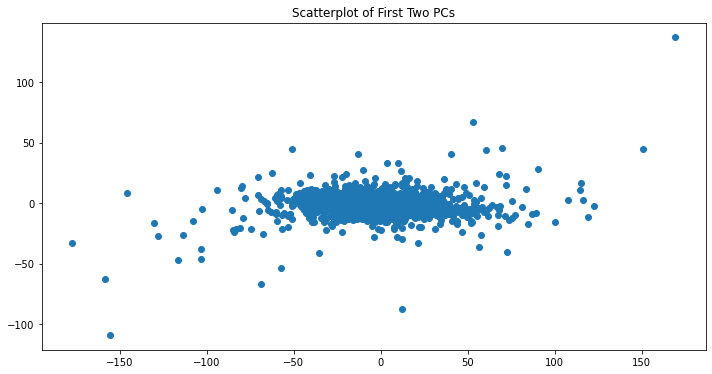

In [7]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(scaled)
combined = np.concatenate([pca.components_, pca.explained_variance_ratio_.reshape(-1,1)], axis=1)
components = pd.DataFrame(
    pca.components_,
    columns=list(stock_names),# + ["Explained Var"],
    index=[f"PC{i+1}" for i in range(pca.n_components_)]
)

if PLOTS:
    #num_stocks = 5
    plt.figure(figsize=(10,10))
    #for i, pc in enumerate(components.index):
    #    plt.subplot(2,pca.n_components_,i+1)
    #    plt.bar(stock_names[:num_stocks], components.loc[pc].iloc[:num_stocks])
    #    plt.title(f"Feature Contributions to PC{i+1}")
    #    plt.ylabel("Loading Score")
    #    plt.xlabel("Features")

    plt.subplot(2,1,2)
    plt.title("Scatterplot of First Two PCs")
    plt.scatter(X_pca[:,0], X_pca[:, 1])

    plt.tight_layout()

### Portfolio Weighting
Your component mixtures are your portfolio weights

In [ ]:
weights = components/data.std(axis=0)
factor_returns = weights.dot(data.T) / len(stock_names)

print(components)
print(data.std(axis=0))
print(weights)
factor_returns

        10026     10032     10044     10065     10104     10107     10138  \
PC1  0.027385  0.030607  0.009365  0.048554  0.028938  0.032639  0.042889   
PC2 -0.004659 -0.021164  0.015391  0.013349 -0.013020 -0.002786 -0.017452   
PC3 -0.018421  0.062926  0.002129  0.036999  0.067057  0.064781  0.012635   
PC4  0.021820 -0.005004 -0.007809  0.022349  0.039897  0.044906  0.021698   
PC5 -0.001452 -0.034533 -0.004410  0.005227 -0.019722 -0.012022 -0.013101   

        10145     10200     10207  ...     88664     88912     89456  \
PC1  0.038647  0.014386  0.036388  ...  0.030571  0.024035  0.027168   
PC2 -0.002639 -0.004105  0.024122  ... -0.019646 -0.003426 -0.015054   
PC3  0.027349  0.028173  0.018530  ...  0.031261 -0.029602 -0.015443   
PC4  0.020828  0.012869 -0.021657  ...  0.045087 -0.024675 -0.009538   
PC5  0.018807 -0.017124  0.009194  ... -0.005206 -0.027341 -0.010027   

        89858     89915     90983     91287     91556     92655     92690  
PC1  0.026382  0.032863  0.0

In [14]:
market_returns = np.mean(data, axis=1)
factor_returns.iloc[0].corr(market_returns)

np.float64(0.995779726171454)

### Finding the Coefficients for Each Factor

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Sample data
X = factor_returns.T
Y = data

# Create a multi-output regression model
model = LinearRegression()
model.fit(X, Y)

coefs = pd.DataFrame(model.coef_, index=data.columns, columns=X.columns)
coefs["alpha"] = model.intercept_

coefs

,PC1,PC2,PC3,PC4,PC5,alpha
10026,0.677897,-0.115325,-0.455992,0.540138,-0.035942,0.000207
10032,1.201440,-0.830755,2.470060,-0.196432,-1.355552,0.000014
10044,0.309076,0.507966,0.070251,-0.257738,-0.145557,0.000371
10065,0.679103,0.186708,0.517480,0.312590,0.073116,-0.000197
10104,0.827907,-0.372503,1.918477,1.141431,-0.564236,-0.000087
...,...,...,...,...,...,...
90983,0.303922,0.394093,-0.417062,-0.542886,-0.109253,0.000433
91287,0.815815,0.487103,0.072117,-1.243717,-0.052716,0.000748
91556,0.783646,-0.200567,0.133245,0.452925,-0.480193,0.000384
92655,0.653097,0.529353,-0.132700,0.988607,0.568679,0.000368


This differs from a Fama-French style regression in that we don't have any external characteristics. In other words, we don't try to guess what the factors that impact the regression are. Instead, we purely try to estimate the factors from our returns. Interestingly, we actually manage to back out the CAPM market factor as shown by the high correlation of PC1 returns with the market.

### Simple Backtest

In [90]:
weights = coefs["alpha"]/(np.sqrt(coefs["alpha"]**2).sum()) * 1000
1 + (np.e ** data - 1) * weights

,10026,10032,10044,10065,10104,10107,10138,10145,10200,10207,...,88664,88912,89456,89858,89915,90983,91287,91556,92655,92690
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,1.009361,0.999154,1.041184,1.002691,0.982181,1.000145,1.032339,1.010392,0.930998,0.992034,...,1.000560,1.019086,1.000536,1.007126,0.994608,1.027212,1.637783,0.956431,1.016042,1.002734
2000-01-04,0.938292,0.998679,1.023847,1.009410,1.027108,1.002993,1.020123,1.010574,1.000000,1.000000,...,0.962427,1.001917,1.000464,1.000000,0.981164,0.980224,0.563925,0.940379,0.982771,0.994635
2000-01-05,1.046541,0.999963,1.000000,1.005464,1.016490,0.999045,1.001238,1.008090,0.929604,0.997861,...,1.009834,0.990237,0.999755,1.015915,0.997210,1.006731,1.302299,1.032194,0.996810,1.000000
2000-01-06,1.002373,1.000074,0.881533,1.000000,1.018312,1.002969,0.979841,0.988191,1.073359,0.995750,...,0.995253,1.000000,1.000143,1.018729,1.028583,0.986679,0.948533,0.857278,1.050533,1.008327
2000-01-07,1.002366,1.000373,1.181518,0.997232,0.974404,0.998815,1.004807,0.966722,1.296403,1.004045,...,1.000000,1.016652,1.000263,1.003177,0.983940,1.000000,1.220170,0.982684,1.168727,0.997327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,1.005285,1.000320,1.012114,0.997100,0.998969,0.999749,0.993652,0.998258,1.012078,0.999362,...,1.005358,0.994067,1.000056,1.000000,1.009054,1.020423,1.000000,1.005620,1.001122,1.004825
2023-12-26,1.002916,1.000230,0.976239,0.993797,1.000030,0.999981,0.994974,0.992901,1.017397,0.999152,...,1.001400,0.994966,0.999887,1.001218,1.006491,1.000000,1.019459,1.006013,0.999271,1.004282
2023-12-27,0.995527,0.999422,0.978817,0.998774,1.000754,1.000142,1.000000,0.997145,1.001520,0.999156,...,0.993312,0.996476,0.999933,1.000242,1.003817,1.008990,1.019323,1.004230,1.007213,1.000936
